In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from itertools import islice
from pathlib import Path
import os

import flax.linen as nn
import h5py
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import seaborn as sns
from flax.training import train_state
from jax import random
from sklearn.manifold import TSNE

from neurovae import Conv1DVAE, sse_loss, gaussian_kld, reparameterize
from helper import fig_path

sns.set_theme(context="paper", style="darkgrid", rc={"axes.facecolor": "0.96"})
fontsize = "x-large"
params = {
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.handlelength": 2,
}
plt.rcParams.update(params)
plt.rc("text", usetex=False)

2024-06-24 16:55:13.167661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
def create_batches(data, batch_size, drop_remainder):

    data_size = data.shape[0]
    remainder = data_size % batch_size

    if drop_remainder and remainder != 0:
        it = iter(data[: data_size - remainder, :])
    else:
        it = iter(data)

    batches = []

    while batch := tuple(islice(it, batch_size)):
        batches.append(jnp.asarray(batch))

    return batches

beta = 1
latent_dim = 20
output_dim = 10000
batch_size = 16
epochs = 50
seed = 42

# prepare HH data
t_sim = 100.0
dt = 0.01
N = int(t_sim / dt)
t = np.linspace(0, t_sim, N)

vs = []
for i in range(10):
    infile = f"./hh_data/hh_sim_data_{i}.h5"
    with h5py.File(infile, "r") as f:
        for grp_name in f.keys():
            v = f[grp_name]["v"][:]
            v_scaled = (v - v.min(keepdims=True)) / (v.max(keepdims=True) - v.min(keepdims=True))
            vs.append(v_scaled)

v_train = vs[:8000]
v_test = vs[8000:]

# cast to jax
v_train = jnp.asarray(v_train, dtype=jnp.float32)
v_test = jnp.asarray(v_test, dtype=jnp.float32)

batches = create_batches(v_train, batch_size, drop_remainder=True)

# set values for learning rate scheduler
total_steps = len(batches) * epochs
init_lr = 1e-3
alpha_lr = 1e-2


def model():
    return Conv1DVAE(latent_dim)


def init_model(rng):
    rng, init_key = random.split(rng)

    initial_variables = jnp.ones((batch_size, output_dim), jnp.float32)
    params = model().init(init_key, initial_variables, rng)["params"]
    del initial_variables, init_key

    lr_schedule = optax.cosine_decay_schedule(init_lr, decay_steps=total_steps, alpha=alpha_lr)
    optimizer = optax.chain(optax.clip(1.0), optax.adamw(lr_schedule, nesterov=True))

    state = train_state.TrainState.create(
        apply_fn=model().apply,
        params=params,
        tx=optimizer,
    )
    return rng, state


def compute_metrics(recon_x, x, mean, logvar):
    mse = sse_loss(recon_x, x).mean()  # mean over batch
    kld = gaussian_kld(mean, logvar).mean()  # mean over batch
    elbo = mse + beta * kld
    return {"elbo": elbo, "mse": mse, "kld": kld}


@jax.jit
def train_step(state, batch, z_rng):

    def loss_fn(params):
        recon_x, mean, logvar = model().apply({"params": params}, batch, z_rng)
        mse = sse_loss(recon_x, batch).mean()
        kld = gaussian_kld(mean, logvar).mean()
        elbo = mse + beta * kld
        return elbo

    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)


@jax.jit
def eval_f(params, v_traces, z, z_rng):
    def eval_model(vae):
        recon_v_traces, mean, logvar = vae(v_traces, z_rng)

        comparison = jnp.concatenate(
            [
                v_traces[:8],
                recon_v_traces[:8],
            ]
        )

        generate_v_traces = vae.generate(z, assumption="gaussian")
        metrics = compute_metrics(recon_v_traces, v_traces, mean, logvar)
        return metrics, comparison, generate_v_traces

    return nn.apply(eval_model, model())({"params": params})

In [6]:
rng = random.key(seed)
rng, state = init_model(rng)

rng, z_key, eval_rng = random.split(rng, 3)

z = random.normal(z_key, (batch_size, latent_dim))  # prior
del z_key

epoch_metrics = []
for epoch in range(epochs):
    for batch in batches:
        rng, key = random.split(rng)
        state = train_step(state, batch, key)

    metrics, comparison, samples = eval_f(state.params, v_test, z, eval_rng)
    metrics["epoch"] = epoch + 1
    epoch_metrics.append(metrics)
    print(f"epoch: {epoch + 1}, ELBO: {metrics['elbo']:.4f}, MSE: {metrics['mse']:.4f}, KLD: {metrics['kld']:.4f}")

epoch: 1, ELBO: 205.0983, MSE: 192.6712, KLD: 12.4271
epoch: 2, ELBO: 178.5541, MSE: 163.9794, KLD: 14.5747
epoch: 3, ELBO: 164.7411, MSE: 149.6743, KLD: 15.0668
epoch: 4, ELBO: 156.3427, MSE: 135.7850, KLD: 20.5576
epoch: 5, ELBO: 149.6115, MSE: 128.0094, KLD: 21.6021
epoch: 6, ELBO: 136.7150, MSE: 114.8568, KLD: 21.8583
epoch: 7, ELBO: 126.5338, MSE: 107.9598, KLD: 18.5740
epoch: 8, ELBO: 148.3022, MSE: 126.7734, KLD: 21.5289
epoch: 9, ELBO: 143.6040, MSE: 125.2292, KLD: 18.3748
epoch: 10, ELBO: 122.6047, MSE: 104.5463, KLD: 18.0584
epoch: 11, ELBO: 106.6123, MSE: 88.6850, KLD: 17.9273
epoch: 12, ELBO: 128.1569, MSE: 110.3695, KLD: 17.7874
epoch: 13, ELBO: 160.3205, MSE: 142.1643, KLD: 18.1562
epoch: 14, ELBO: 120.4190, MSE: 103.9554, KLD: 16.4637
epoch: 15, ELBO: 132.5639, MSE: 115.3362, KLD: 17.2276
epoch: 16, ELBO: 156.5285, MSE: 140.1083, KLD: 16.4202
epoch: 17, ELBO: 124.6385, MSE: 107.5910, KLD: 17.0475
epoch: 18, ELBO: 116.8767, MSE: 100.9847, KLD: 15.8920
epoch: 19, ELBO: 129

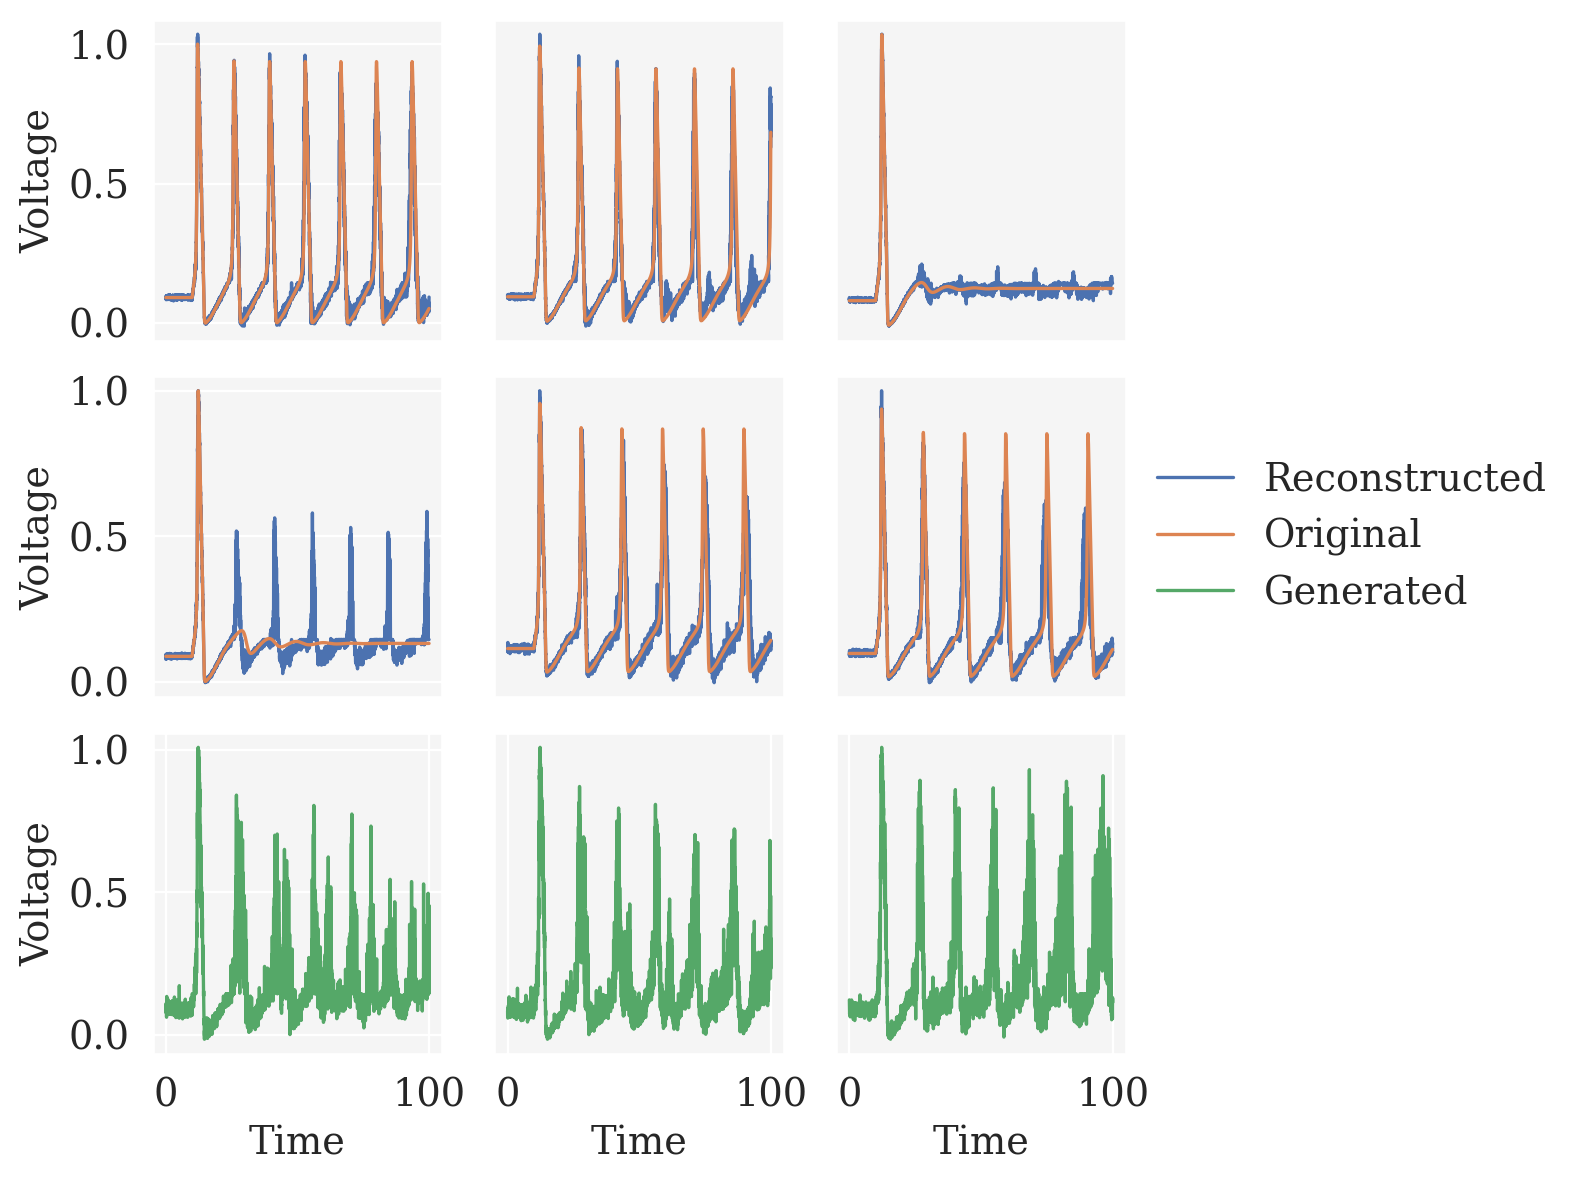

In [4]:
v_org = comparison[:8]
v_recon = comparison[8:]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 6), tight_layout=True)

axes[0, 0].plot(t, v_recon[0], "C0")
axes[0, 0].plot(t, v_org[0], "C1")
axes[0, 0].set(ylabel="Voltage", xticks=[])

axes[0, 1].plot(t, v_recon[1], "C0")
axes[0, 1].plot(t, v_org[1], "C1")
axes[0, 1].set(xticks=[], yticks=[])

axes[0, 2].plot(t, v_recon[2], "C0")
axes[0, 2].plot(t, v_org[2], "C1")
axes[0, 2].set(xticks=[], yticks=[])

axes[1, 0].plot(t, v_recon[3], "C0")
axes[1, 0].plot(t, v_org[3], "C1")
axes[1, 0].set(ylabel="Voltage", xticks=[])

axes[1, 1].plot(t, v_recon[4], "C0")
axes[1, 1].plot(t, v_org[4], "C1")
axes[1, 1].set(xticks=[], yticks=[])

axes[1, 2].plot(t, v_recon[5], "C0", label="Reconstructed")
axes[1, 2].plot(t, v_org[5], "C1", label="Original")
axes[1, 2].set(xticks=[], yticks=[])
axes[1, 2].plot([], [], "C2", label="Generated")

axes[2, 0].plot(t, samples[0], "C2")
axes[2, 0].set(xlabel="Time", ylabel="Voltage")
axes[2, 1].plot(t, samples[1], "C2")
axes[2, 1].set(xlabel="Time", yticks=[])
axes[2, 2].plot(t, samples[2], "C2")
axes[2, 2].set(xlabel="Time", yticks=[])

handles, labels = axes[1, 2].get_legend_handles_labels()
axes[1, 2].legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(1.04, 0.5),
    fancybox=True,
    borderaxespad=0.1,
    ncol=1,
    frameon=False,
)

fig.savefig(fig_path(f"hh_conv_vae_beta_{beta}_z_{latent_dim}.pdf"), bbox_inches="tight")

In [17]:
enc_rng = random.key(seed * seed)
_, mean, logvar = model().apply({"params": state.params}, v_test[:500], enc_rng)
z = reparameterize(enc_rng, mean, logvar)
z = np.array(z)
z_embedded = TSNE(n_components=2, learning_rate="auto", perplexity=30, early_exaggeration=12.0).fit_transform(z)

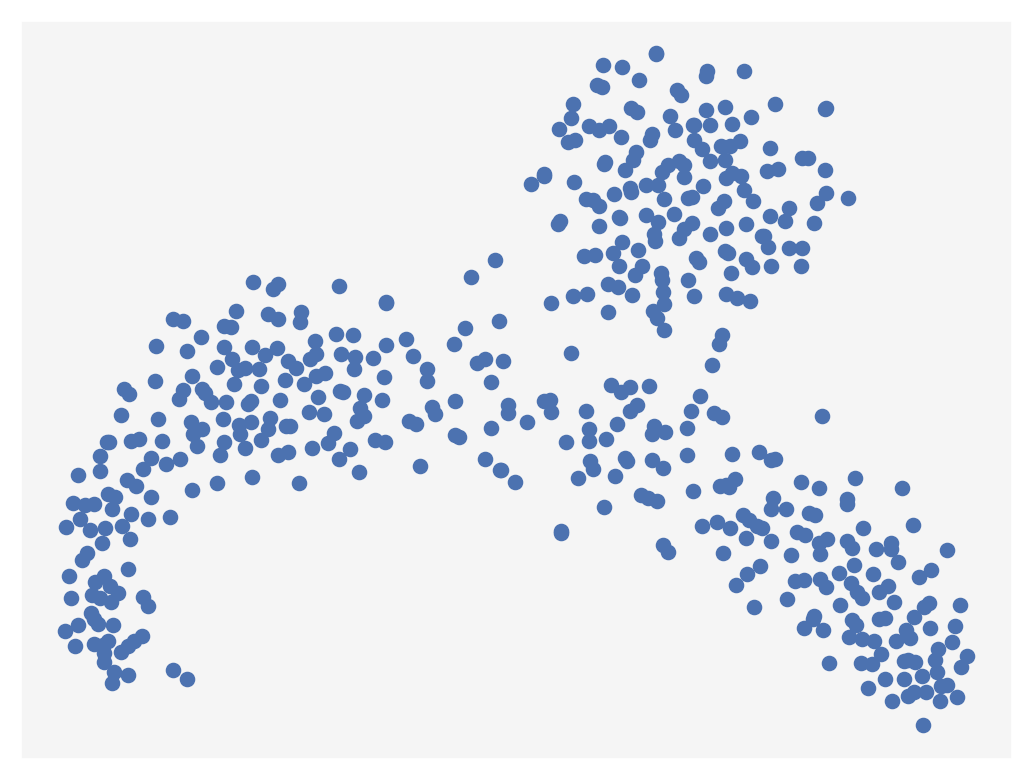

In [18]:
fig = plt.figure()
plt.scatter(z_embedded[:, 0], z_embedded[:, 1])
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

fig.savefig(fig_path(f"hh_tsne_conv_vae_beta_{beta}_z_{latent_dim}.pdf"), bbox_inches="tight")